##Phylogenetic tree generator (for supertrees)

##Générateur d'arbres phylogénétiques (pour les super-arbres)

This generator can be used to generate a specified number of phylogenetic trees in Newick format with a variable number of leaves and with some level of overlap between trees. With this tool, the user can generate a dataset with trees (particularly, gene trees with **horizontal gene transfer** implemented), which is saved in txt, with the possibility of its further use in their scientific experiments (e.g., testing classification algorithms or inference supertrees).


Contributors: AK and NT

The generator is based on the use of the [AsymmeTree library](https://github.com/david-schaller/AsymmeTree).
The user has to specify several initial parameters:

*   The minimum possible number of leaves for each tree
*   The maximum possible number of leaves for each tree
*   The average level of overlap (common leaves) between the trees in the set. We will define the level of overlap between two trees as the number of common leaves (between these trees) divided by the summed length of these trees minus the number of common leaves.

To generate species and gene trees with horizintal gene transfer we use this library: https://github.com/david-schaller/AsymmeTree

**Generator**

We need to install the required libraries


In [ ]:
pip install ete3 PyQt5 asymmetree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.9 MB/s 
     |████████████████████████████████| 8.3 MB 11.2 MB/s 
     |████████████████████████████████| 91 kB 4.5 MB/s 
     |████████████████████████████████| 338 kB 10.6 MB/s 
     |████████████████████████████████| 59.9 MB 137 kB/s 
     |████████████████████████████████| 72 kB 422 kB/s 
  Created wheel for ete3: filename=ete3-3.1.2-py3-none-any.whl size=2273013 sha256=9c7ac749cd397186cfc999e47d78c472a8fa4f9072a8760962668f225d63bd7b
  Stored in directory: /root/.cache/pip/wheels/17/fd/e2/6ac384d8c2484789304657dde01b96d7ab83f4f1dd96d266df
Successfully built ete3


In [ ]:
#Importing the required libraries
import PyQt5
from ete3 import Tree, PhyloTree, TreeStyle
import random
import asymmetree.treeevolve as te
from asymmetree.tools.PhyloTreeTools import to_newick
import pandas as pd

**Setting the required initial values by the user**

*   **Lmin** = the minimum possible number of leaves for each tree, integer (5<=Lmin<500)
*   **Lmax** = the maximum possible number of leaves for each tree, integer (Lmin<Lmax<=500)
*   **Ngen** = the number of trees to be generated, integer (Ngen<=500)
*   **Plevel** = the average level of overlap (common leaves) between the trees in the set, in decimal notation, from 0.2 to 0.7 with steps of 0.5 (which corresponds to the range from 20% to 70%)

Currently, the generator works very slow for the levels of overlap <0.2 and >0.7.

In [ ]:
Lmin =   15#@param {type:"integer", min:5, max:499}
Lmax =   25#@param {type:"integer", min:6, max:500}
Ngen =  30#@param {type:"integer", min:3, max:500}
plevel = 0.5 #@param {type:"slider", min:0.2, max:0.75, step:0.5}



In [ ]:
#Checking values
if Lmin < 5 or Lmin >499 or Lmin > Lmax or Lmin==Lmax or Lmax >500 or Ngen < 3 or Ngen >500:
  print('Check if the range of the entered data is correct. Select another value, please')
  raise ValueError


In [ ]:
#Generating the first tree
# We will base our calculation of the overlap level on the first tree
#the first tree will include Lmax leaves

Sf1 = te.species_tree_n(Lmax, model='yule') #generating a species tree
tree_simulator_f1 = te.GeneTreeSimulator(Sf1)
Tf1 = tree_simulator_f1.simulate(hgt_rate=0.2, loss_rate=0.2, replace_prob=1) #generating a gene tree with horizontal gene transfer

# take the observable part of a gene tree
#it copies the tree, removes all branches that lead to loss events only and suppresses all inner nodes with only one child.
# It also removes the planted root.
ogt1 = te.prune_losses(Tf1)
ogt1 = to_newick(ogt1, reconc=False)
First_tree = Tree(ogt1, format=1)
First_sp1 = to_newick(Sf1, reconc=False)
First_sp = Tree(First_sp1, format=1) #the first species tree in Newick format

In the next step we will generate new trees (with the specified basic parameters) and check how this tree affects the average level of overlap in the dataset. If they overlap in the specified range (plevel-0.01; plevel+0.01), we will save this new tree to our dataset. We will continue to do this until we have the required number of trees (Ngen).

In [ ]:
# if we need to provide the average level of overlap between each pair of trees

species_trees = [] #declare an empty list for species trees
tree_dataset = [] #declare an empty list for gene trees
species_trees.append(First_sp) #add the first species tree
tree_dataset.append(First_tree) #add the first gene tree
common_leaves_temp = []
#overlap_tempset = []
overlap_set1 = []
while len(tree_dataset) < Ngen:
  temp_set = tree_dataset #temp_set is to store trees temporarily
  overlap_tempset = overlap_set1
  N1 = random.randrange(Lmin, Lmax) #we randomly chose the number of leaves for the generated tree in the specified range
  S1 = te.species_tree_n(N1) #generate next species tree
  tree_simulator = te.GeneTreeSimulator(S1)
  T1 = tree_simulator.simulate(hgt_rate=0.2, loss_rate=0.2,  replace_prob=1) # we set the horizontal gene transfer rate to 0.2
  ogt = te.prune_losses(T1)
  ogt = to_newick(ogt, reconc=False)
  Tr1 = Tree(ogt, format=1) #it's our next gene tree
  # in the next step we will check the level of overlap and add trees to our dataset
  overlap_tempset =[]
  common_leaves_temp = []
  for i in range (0, len(temp_set)):
    rf, max_rf, common_leaves, parts_t1, parts_t2, discard_t1, discart_t2 = Tr1.robinson_foulds(temp_set[i], unrooted_trees=True)
    # we used the robinson_foulds function to get common leaves for each pairs of trees
    overlap_level_temp = len(common_leaves)/(len(Tr1)+len(temp_set[i]) - len(common_leaves)+0.001)
    overlap_tempset.append(overlap_level_temp)
  average_overlap = pd.Series(overlap_tempset) #calculation of the average level of overlap in the current version of our dataset
  if (average_overlap.mean() <= plevel+0.01) and (average_overlap.mean() >= plevel-0.01):
    overlap_set1.append(overlap_level_temp)
    tree_dataset.append(Tr1) #we add the generated gene tree to our dataset if this tree satisfies our conditions
    Spt1 = to_newick(S1, reconc=False)
    Spt2 = Tree(Spt1, format=1)
    species_trees.append(Spt2)
    #species_trees.append(Tree(to_newick(S1, color=False), format=1))
    print("Now we have ", len(tree_dataset), " trees") #we display the current number of trees in our dataset to see the progress
print("All done. Good job!")

Now we have  2  trees
Now we have  3  trees
Now we have  4  trees
Now we have  5  trees
Now we have  6  trees
Now we have  7  trees
Now we have  8  trees
Now we have  9  trees
Now we have  10  trees
Now we have  11  trees
Now we have  12  trees
Now we have  13  trees
Now we have  14  trees
Now we have  15  trees
Now we have  16  trees
Now we have  17  trees
Now we have  18  trees
Now we have  19  trees
Now we have  20  trees
Now we have  21  trees
Now we have  22  trees
Now we have  23  trees
Now we have  24  trees
Now we have  25  trees
Now we have  26  trees
Now we have  27  trees
Now we have  28  trees
Now we have  29  trees
Now we have  30  trees
All done. Good job!


In [ ]:
# Let's check the final number of unique trees in our dataset
print("Desired number of trees = ", Ngen)
print("Real number of trees = ", len(tree_dataset))
print("Number of uniques trees in the dataset = ", len(set(tree_dataset)))

Desired number of trees =  30
Real number of trees =  30
Number of uniques trees in the dataset =  30


In [ ]:
# now we write the generated gene trees to a txt file (trees in Newick format).

genedataset = "genetrees_%s" % (int(plevel*100))
with open(r"%s.txt" % genedataset, "w") as file:
#write trees into the file line by line
  for tree in tree_dataset:
    file.write(tree.write() + '\n')
file.close() #close the file for writing

In [ ]:
# if we need a dataset of generated species trees, we need to launch this cell
# we may need it, for example, for HGT-Detection (e.g. http://www.trex.uqam.ca/index.php?action=hgt&project=trex)

speciesdataset = "speciestrees_%s" % (int(plevel*100))
with open(r"%s.txt" % speciesdataset, "w") as file:
#write trees into the file line by line
  for tree in species_trees:
    file.write(tree.write() + '\n')
file.close() #close the file for writing


The generated dataset of the specified number of trees (gene trees and/or species trees) in Newick format is saved in the folder (e.g. genetrees_50.txt file, where the number indicates the level of overlap), from which the code was launched, or in the "Files" section, if launched in colab


#Checking the generated dataset
1. Reading txt file with generated trees line by line
2. Assigning tree1, tree2 etc. names to trees from a file
3. Visualization of several trees
4. Pairwise calculation of the specified number of trees with the number of common leaves (through robinson_foulds)
5. Calculation of additional parameters for testing


In [ ]:
# testing number of leaves in the trees

for i in range(0, Ngen):
  print(len(species_trees[i]), " | ", len(tree_dataset[i]))


25  |  25
20  |  20
24  |  24
22  |  22
23  |  23
22  |  22
22  |  22
23  |  23
23  |  23
21  |  21
24  |  24
21  |  21
24  |  24
24  |  24
22  |  22
22  |  22
22  |  22
24  |  24
22  |  22
22  |  22
24  |  24
24  |  24
21  |  21
23  |  23
24  |  24
22  |  22
24  |  24
20  |  20
22  |  22
23  |  23


In [ ]:
#Display 2 examples of generated trees. 
#If necessary, you can select other trees

print("Tree 1: ", tree_dataset[1])
print("Tree 3: ", tree_dataset[3])


### Calculation of the average level of overlap

 We define the level of overlap between two trees as the number of common leaves (between these trees) divided by the summed length of these trees minus the number of common leaves.

In [ ]:
#go through all trees from the file with the collection of generated trees
#count the number of common leaves for each pair of trees, using robinson_foulds function
common_leaves_set = []
overlap_set = []
for i in range (0, len(tree_dataset)-1):
  for j in range(i+1, len(tree_dataset)):
    rf, max_rf, common_leaves, parts_t1, parts_t2, discard_t1, discart_t2 = tree_dataset[i].robinson_foulds(tree_dataset[j], unrooted_trees=True)
    common_leaves_set.append(len(common_leaves))
    overlap_level = len(common_leaves)/(len(tree_dataset[i])+len(tree_dataset[j]) - len(common_leaves))
    overlap_set.append(overlap_level)
    #print('For trees ', i+1, j+1, ' ', len(common_leaves))

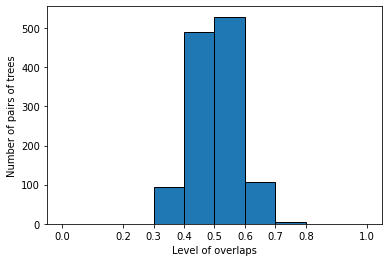

In [ ]:
# Let's look at the distribution of overlap levels in our dataset
import matplotlib.pyplot as plt
import pandas as pd
ov1 = pd.Series(overlap_set)

bins= [0,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]
plt.hist(ov1.values, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.xlabel('Level of overlaps')
plt.ylabel('Number of pairs of trees')
plt.show()

In [ ]:
#See the statistics on the number of common leaves
s = pd.Series(common_leaves_set)
s.describe(percentiles=[.25, .5, .75, .80, .85, .90, .95])

count    1225.000000
mean       14.835102
std         1.663401
min        10.000000
25%        14.000000
50%        15.000000
75%        16.000000
80%        16.000000
85%        17.000000
90%        17.000000
95%        17.000000
max        20.000000
dtype: float64

Note the values of the number of common leaves: 'mean', 'min', 'max' (with 95% quartile)

In [ ]:
#Check the actual average level of overlap
print("Desired level of overlap = ", plevel)

# average level of overlap
average_overlap = pd.Series(overlap_set)
print("Average level of overlap between each pair of trees = ", average_overlap.mean())


Desired level of overlap =  0.5
Average level of overlap between each pair of trees =  0.4985224530410263


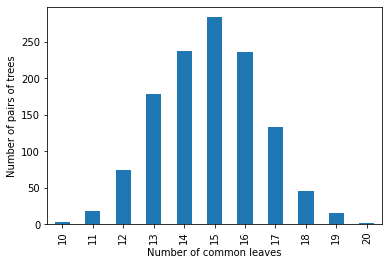

In [ ]:
#Visualize the distribution of the number of common leaves
s.value_counts().sort_index().plot(kind="bar", xlabel = "Number of common leaves", ylabel = "Number of pairs of trees")

This distribution is close to a normal distribution

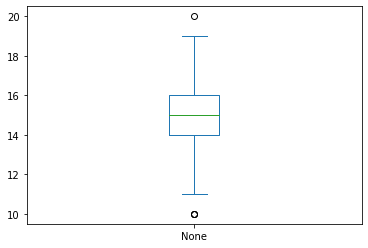

In [ ]:
s.plot(kind = 'box')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


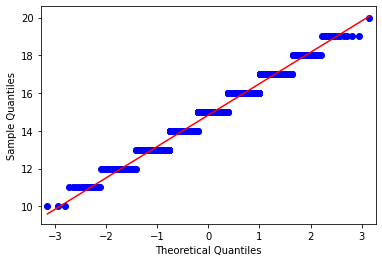

In [ ]:
#Q-Q Plot

import statsmodels.api as sm
import pylab

sm.qqplot(s, line='s')
pylab.show()
